The HABS-HD project is unique and critical to our understanding of the biology of the brain because it examines MCI and AD risk among all populations and communities. This is the first-ever large-scale study of Amyloid/Tau/Neurodegeneration pathological markers (and Framework) among a community-based cohort. Research shows that some populations will experience a significantly greater increased incidence of Mild Cognitive Impairment (MCI) and AD than others. This sets the stage for precision medicine when advancing novel diagnostics and therapeutics for treating and preventing MCI and AD across populations.
The PIs of this study have restricted the information available for this study. 

# Setup and Libraries

In [205]:
# Cell 0: get current notebook path, its parent, and project root (parent of parent)
import os
from pathlib import Path

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: improve plots appearance
sns.set(style="whitegrid")

ROOT_DIR = Path(os.getcwd()).resolve().parent


# Load the CSV and parse Imaging Protocol

In [206]:
CSV_DIR = ROOT_DIR / "csv_dir"
original_df = pd.read_csv(CSV_DIR / "HABS_all.csv")


# little adjustments
original_df["Subject ID"] = original_df["Subject ID"].astype("category")
original_df["Image ID"] = original_df["Image ID"].astype("category")
original_df["Weight"] = original_df["Weight"].replace(0, np.nan)
original_df["Age"] = original_df["Age"].replace(0, np.nan)
original_df["Study Date"] = pd.to_datetime(original_df["Study Date"], errors="coerce")

print(original_df.columns)
print(len(original_df))

fields = [
    "Acquisition Plane",
    "Slice Thickness",
    "Matrix Z",
    "Acquisition Type",
    "Manufacturer",
    "Mfg Model",
    "Field Strength",
    "Weighting",
]

numeric_fields = ["Slice Thickness", "Matrix Z", "Field Strength"]


def parse_imaging_protocol(text):
    if pd.isna(text):
        return {}

    items = text.split(";")
    parsed = {}

    for item in items:
        if "=" in item:
            key, value = item.split("=", 1)
            parsed[key.strip()] = value.strip()

    return parsed


# Parse the column into dictionaries
protocol_parsed = original_df["Imaging Protocol"].apply(parse_imaging_protocol)

# Create new columns
for field in fields:
    original_df[field] = protocol_parsed.apply(lambda x: x.get(field, np.nan))


for field in numeric_fields:
    original_df[field] = pd.to_numeric(original_df[field], errors="coerce")

print(original_df.columns)

Index(['Subject ID', 'Project', 'Sex', 'Weight', 'Visit', 'Study Date',
       'Archive Date', 'Age', 'Modality', 'Description', 'Type',
       'Imaging Protocol', 'Image ID'],
      dtype='object')
113403
Index(['Subject ID', 'Project', 'Sex', 'Weight', 'Visit', 'Study Date',
       'Archive Date', 'Age', 'Modality', 'Description', 'Type',
       'Imaging Protocol', 'Image ID', 'Acquisition Plane', 'Slice Thickness',
       'Matrix Z', 'Acquisition Type', 'Manufacturer', 'Mfg Model',
       'Field Strength', 'Weighting'],
      dtype='object')


# Filtered dataframe

### Données catégorsiées comme 3D T1, avec Matrix Z > 100 et Slice Thickness < 1.4

In [207]:
# # Apply filters
# df = original_df[
#     (original_df["Modality"] == "MRI")
#     & (original_df["Weighting"] == "T1")
#     & (original_df["Matrix Z"] > 100)
#     & (original_df["Slice Thickness"] < 1.4)
#     & (original_df["Acquisition Type"] == "3D")
#     & (original_df["Type"] == "Original")
# ].copy()
# print(
#     f"Filtered dataset size: {df.shape[0]} images from {df['Subject ID'].nunique()} subjects."
# )

### Données 3D T1 Slice Thickness <=2

In [208]:
# # Apply filters
# df = original_df[
#     (original_df["Modality"] == "MRI")
#     & (original_df["Weighting"] == "PD")
#     & (original_df["Description"].str.contains("T1", case=False, na=False))
#     & (original_df["Matrix Z"] > 100)
#     & (original_df["Slice Thickness"] < 1.4)
#     & (original_df["Acquisition Type"] == "3D")
#     & (original_df["Type"] == "Original")
# ].copy()
# print(
#     f"Filtered dataset size: {df.shape[0]} images from {df['Subject ID'].nunique()} subjects."
# )

In [209]:
# Apply filters
weighting_filter = original_df["Weighting"] == "T1"

df = original_df[
    (original_df["Modality"] == "MRI")
    & weighting_filter
    & (original_df["Acquisition Type"] == "3D")
    & (original_df["Type"] == "Original")
    # & (original_df["Matrix Z"] > 100)
    & (original_df["Slice Thickness"] <= 2)
].copy()

print(
    f"Filtered dataset size: {df.shape[0]} images from {df['Subject ID'].nunique()} subjects."
)

Filtered dataset size: 7060 images from 1737 subjects.


### No filter

In [210]:
# df = original_df

In [211]:
df.head(2)

,Subject ID,Project,Sex,Weight,Visit,Study Date,Archive Date,Age,Modality,Description,...,Imaging Protocol,Image ID,Acquisition Plane,Slice Thickness,Matrix Z,Acquisition Type,Manufacturer,Mfg Model,Field Strength,Weighting
63655,7505,HABS_HD,F,158.8,Baseline,2020-12-14,6/30/2024,60.0,MRI,Mag_Images,...,Acquisition Plane=AXIAL;Slice Thickness=2.0;Ma...,1387299,AXIAL,2.0,72.0,3D,SIEMENS,Skyra,3.0,T1
63657,7505,HABS_HD,F,158.8,Baseline,2020-12-14,6/30/2024,60.0,MRI,SWI_Images,...,Acquisition Plane=AXIAL;Slice Thickness=2.0;Ma...,1387301,AXIAL,2.0,72.0,3D,SIEMENS,Skyra,3.0,T1


# Basic descriptions

In [212]:
# -------------------------------
# Column Names
# -------------------------------
print("=== Columns in the Dataset ===")
display(pd.DataFrame(df.columns, columns=["Column Names"]))

# -------------------------------
# Summary of Numeric Features
# -------------------------------
print("\n=== Numeric Features Summary ===")
display(df.describe().round(2))  # round to 2 decimals

# -------------------------------
# Summary of Categorical Features
# -------------------------------
print("\n=== Categorical Features Summary ===")
display(df.describe(include=["object", "category"]))

# -------------------------------
# Missing Values
# -------------------------------
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df) * 100).round(2)
missing_df = pd.DataFrame(
    {"Missing Count": missing_count, "Missing %": missing_percent}
).sort_values(by="Missing Count", ascending=False)

print("\n=== Missing Values by Column ===")
display(missing_df)

# Find columns with at least one missing value
cols_with_missing = df.columns[df.isnull().any()]
print(f"Columns with missing values ({len(cols_with_missing)}):\n")

# for col in cols_with_missing:
#     print(f"--- {col} ---")
#     # Show up to 5 rows where this column is missing
#     display(df[df[col].isnull()].head(3))

=== Columns in the Dataset ===


,Column Names
0,Subject ID
1,Project
2,Sex
3,Weight
4,Visit
5,Study Date
6,Archive Date
7,Age
8,Modality
9,Description



=== Numeric Features Summary ===


,Weight,Study Date,Age,Slice Thickness,Matrix Z,Field Strength
count,7060.00,7060,7060.00,7060.0,7060.00,7060.0
mean,111.79,2019-01-14 02:28:29.235127552,66.43,2.0,71.95,3.0
min,50.30,2017-03-24 00:00:00,50.00,2.0,53.00,3.0
25%,100.70,2018-03-08 00:00:00,60.00,2.0,72.00,3.0
50%,105.20,2018-12-20 00:00:00,66.00,2.0,72.00,3.0
75%,105.20,2019-10-25 00:00:00,72.00,2.0,72.00,3.0
max,201.40,2020-12-21 00:00:00,92.00,2.0,80.00,3.0
std,19.21,NaN,8.65,0.0,1.09,0.0



=== Categorical Features Summary ===


,Subject ID,Project,Sex,Visit,Archive Date,Modality,Description,Type,Imaging Protocol,Image ID,Acquisition Plane,Acquisition Type,Manufacturer,Mfg Model,Weighting
count,7060,7060,7060,7060,7060,7060,7060,7060,7060,7060,7060,7060,7060,7060,7060
unique,1737,1,2,2,3,1,3,1,5,7060,1,1,1,1,1
top,9927,HABS_HD,F,Baseline,6/29/2024,MRI,SWI_Images,Original,Acquisition Plane=AXIAL;Slice Thickness=2.0;Ma...,1333104,AXIAL,3D,SIEMENS,Skyra,T1
freq,6,7060,4359,5182,3792,7060,2355,7060,6932,1,7060,7060,7060,7060,7060



=== Missing Values by Column ===


,Missing Count,Missing %
Subject ID,0,0.0
Project,0,0.0
Sex,0,0.0
Weight,0,0.0
Visit,0,0.0
Study Date,0,0.0
Archive Date,0,0.0
Age,0,0.0
Modality,0,0.0
Description,0,0.0


Columns with missing values (0):



# Histograms

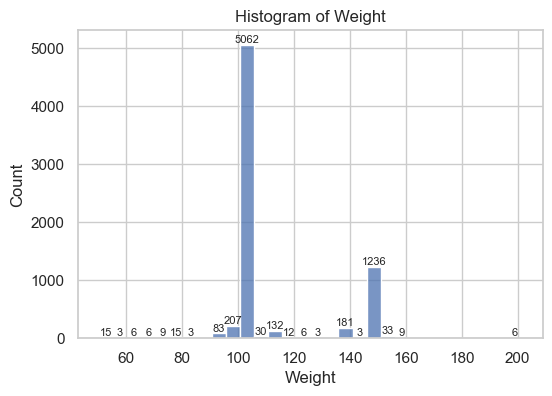

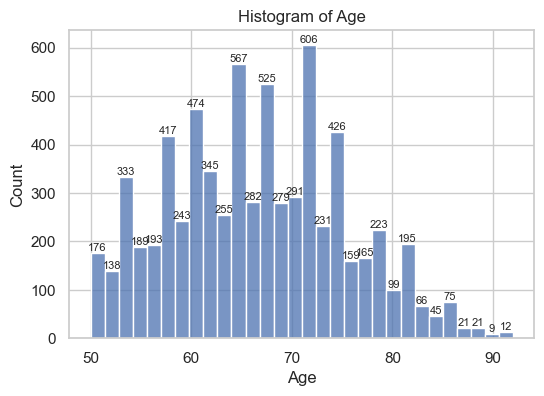

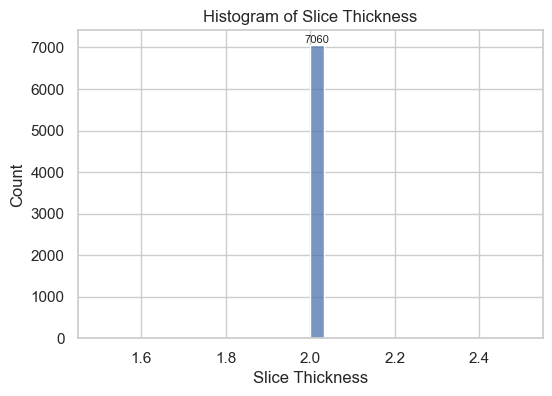

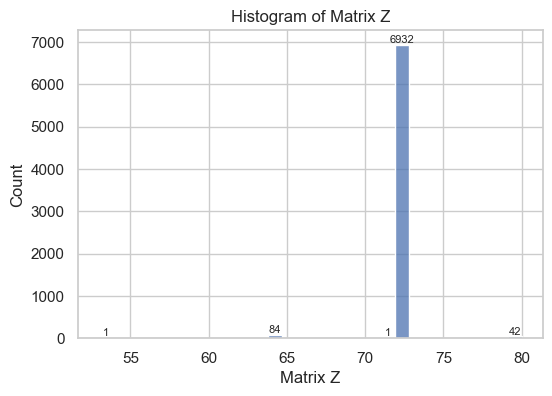

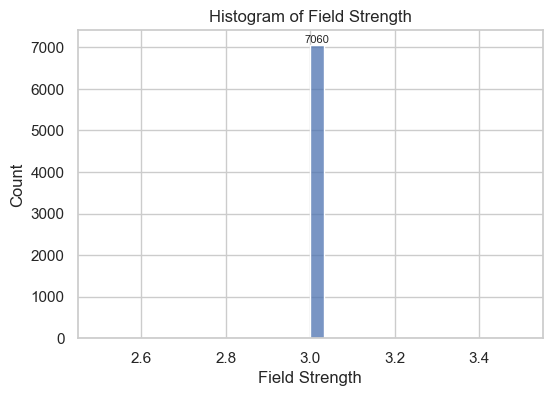

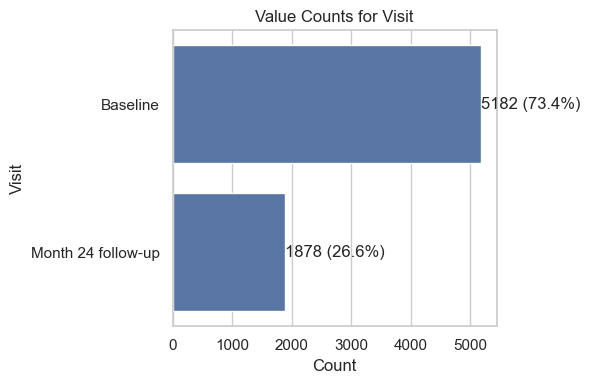

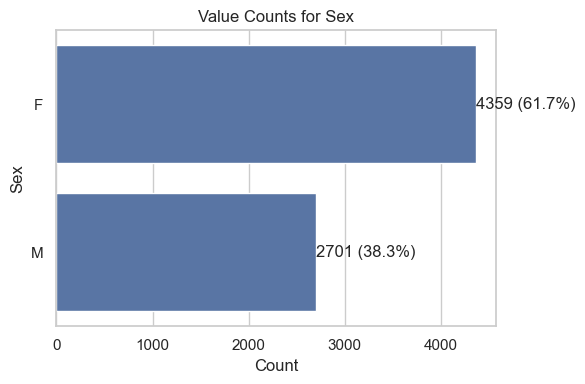

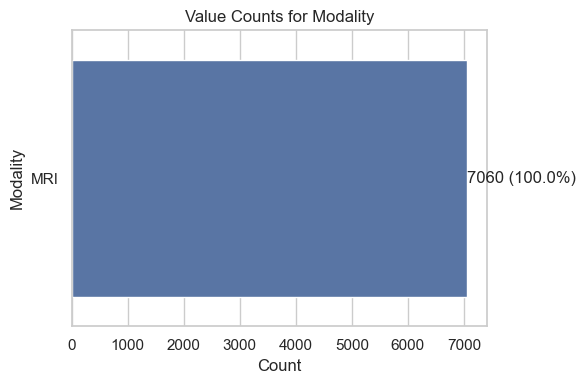

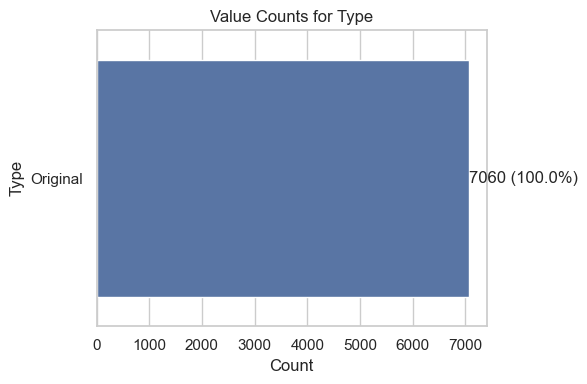

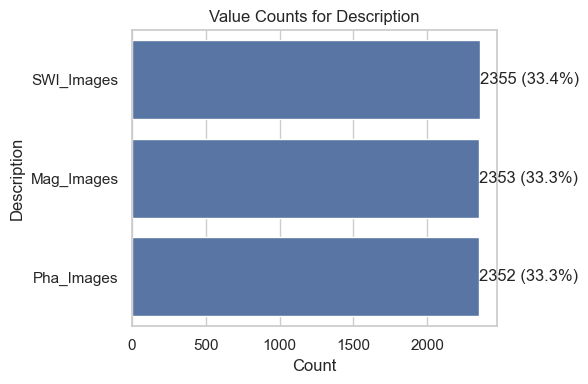

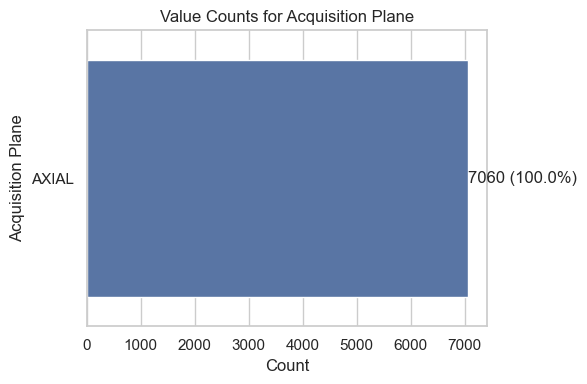

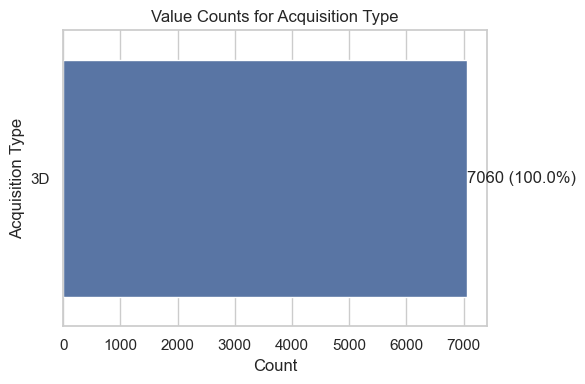

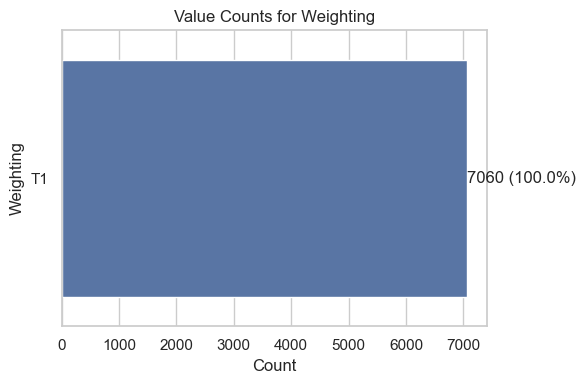

In [213]:
# Separate numeric and categorical columns
numeric_cols = df.select_dtypes(include=np.number).columns
categorical_cols = df.select_dtypes(include=["object", "category"]).columns

# -------------------------------
# Numeric Columns Histograms
# -------------------------------
for col in numeric_cols:
    plt.figure(figsize=(6, 4))

    # Plot histogram
    ax = sns.histplot(
        df[col].dropna(), bins=30, kde=False
    )  # disable KDE for counts clarity

    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

    # Annotate counts on top of each bin
    for patch in ax.patches:
        height = patch.get_height()
        if height > 0:  # only annotate non-empty bins
            ax.text(
                patch.get_x() + patch.get_width() / 2,  # center of bin
                height + 0.5,  # slightly above the bar
                int(height),  # show integer count
                ha="center",
                va="bottom",
                fontsize=8,
            )

    plt.show()

# -------------------------------
# Categorical Columns Bar Plots
# -------------------------------
categorical_cols = [
    "Visit",
    "Sex",
    "Research Group",
    "Modality",
    "Type",
    "Structure",
    "Laterality",
    "Image Type",
    "Registration",
    "Tissue",
    "Description",
    # Imaging Protocol–derived categorical columns
    "Acquisition Plane",
    "Acquisition Type",
    # "Manufacturer",
    # "Mfg Model",
    "Weighting",
]

categorical_cols = [col for col in categorical_cols if col in df.columns]
for col in categorical_cols:
    plt.figure(figsize=(6, 4))

    counts = df[col].value_counts(dropna=False)
    total = counts.sum()
    order = counts.index

    ax = sns.countplot(y=col, data=df, order=order)

    # Add count + percentage labels
    for p, category in zip(ax.patches, order):
        count = counts[category]
        percent = 100 * count / total

        ax.text(
            p.get_width() + 0.5,
            p.get_y() + p.get_height() / 2,
            f"{count} ({percent:.1f}%)",
            va="center",
        )

    plt.title(f"Value Counts for {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()


# Study dates

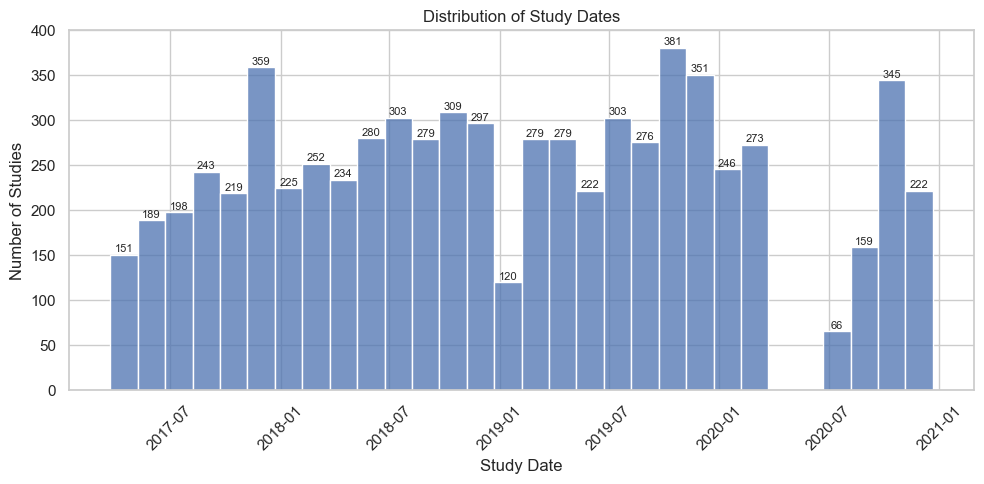

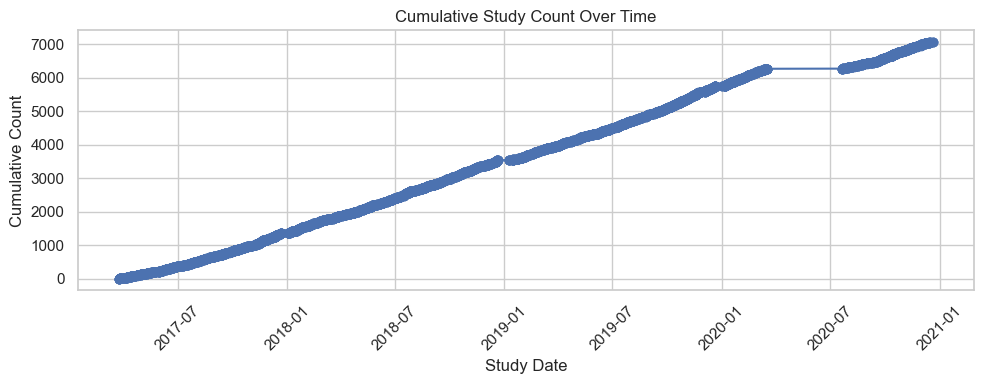

In [214]:
# -------------------------------
# Study Date Distribution
# -------------------------------


plt.figure(figsize=(10, 5))

# Histogram of study dates
ax = sns.histplot(df["Study Date"].dropna(), bins=30, kde=False)

plt.title("Distribution of Study Dates")
plt.xlabel("Study Date")
plt.ylabel("Number of Studies")

# Annotate counts on top of each bin
for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height + 0.5,
            int(height),
            ha="center",
            va="bottom",
            fontsize=8,
        )

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# cumulative study count over time
plt.figure(figsize=(10, 4))
df_sorted = df.sort_values("Study Date")
df_sorted["Cumulative Count"] = range(1, len(df_sorted) + 1)
plt.plot(
    df_sorted["Study Date"], df_sorted["Cumulative Count"], marker="o", linestyle="-"
)
plt.title("Cumulative Study Count Over Time")
plt.xlabel("Study Date")
plt.ylabel("Cumulative Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Scans per session / coverage

Does a subject have more than one scan at a given visit?

How often does this happen?

In [215]:
df["Visit"] = df["Visit"].astype(str)

# scans per subject per visit
scans_per_subject_visit = (
    df.groupby(["Subject ID", "Visit"], observed=True)
    .size()
    .reset_index(name="n_scans")
)
# Keep only rows with at least 1 scan
scans_per_subject_visit = scans_per_subject_visit[
    scans_per_subject_visit["n_scans"] > 0
].copy()
# print(scans_per_subject_visit.head())
# print(scans_per_subject_visit["n_scans"].min())  # should now be >= 1


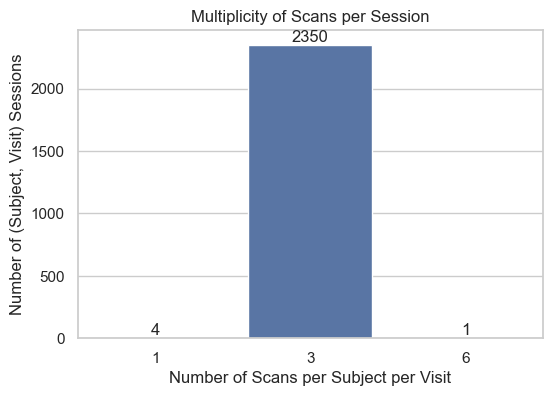

In [216]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    x="n_scans",
    data=scans_per_subject_visit,
    order=sorted(scans_per_subject_visit["n_scans"].unique()),
)

plt.xlabel("Number of Scans per Subject per Visit")
plt.ylabel("Number of (Subject, Visit) Sessions")
plt.title("Multiplicity of Scans per Session")

# Annotate counts on top of bars
for p in ax.patches:
    ax.annotate(
        int(p.get_height()),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
    )

plt.show()


# Longitudinal analysis - for filtered subset

In [217]:
df["Visit"].unique()

array(['Baseline', 'Month 24 follow-up'], dtype=object)

In [218]:
import re
import numpy as np

visit_values = df["Visit"].unique()

scheduled_visits = {}
event_visits = []

for v in visit_values:
    v_clean = str(v).strip()

    if v_clean.lower() == "baseline":
        scheduled_visits[v_clean] = 0
    elif re.match(r"Month\s*(\d+)", v_clean, re.IGNORECASE):
        month_num = int(re.match(r"Month\s*(\d+)", v_clean, re.IGNORECASE).group(1))
        scheduled_visits[v_clean] = month_num
    else:
        event_visits.append(v_clean)

print("Scheduled Visits:", scheduled_visits)
print("Event Visits:", event_visits)


Scheduled Visits: {'Baseline': 0, 'Month 24 follow-up': 24}
Event Visits: []


Longitudinal Coverage per Subject (Scheduled Visits):


count    1737.000000
mean        1.355786
std         0.478889
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         2.000000
Name: Visit_Months, dtype: float64

/tmp/ipykernel_21218/1214308047.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=visit_counts.index, y=visit_counts.values, palette="Blues_d")


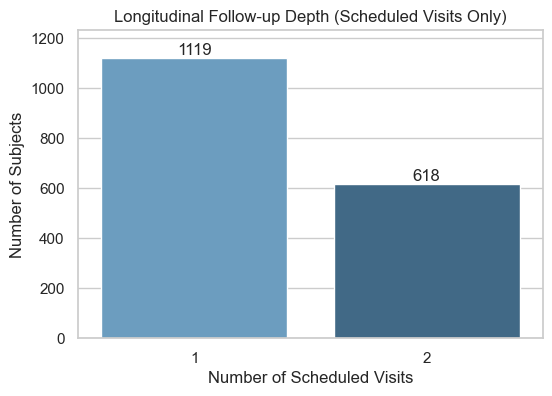

In [219]:
# Map scheduled visits to months and define visit type
df["Visit_Months"] = df["Visit"].map(scheduled_visits)
df["Visit_Type"] = np.where(
    df["Visit"].isin(scheduled_visits.keys()), "Scheduled", "Event"
)

# Keep only scheduled visits
scheduled_df = df[df["Visit_Type"] == "Scheduled"].copy()

# Count unique scheduled visits per subject
visits_per_subject = (
    scheduled_df.groupby("Subject ID", observed=True)["Visit_Months"]
    .nunique()
    .sort_values(ascending=False)
)

# Summary statistics
summary_stats = visits_per_subject.describe()
print("Longitudinal Coverage per Subject (Scheduled Visits):")
display(summary_stats)

# -------------------------------
# Plot barplot with counts on top
# -------------------------------
# Count how many subjects have each number of visits
visit_counts = visits_per_subject.value_counts().sort_index()

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=visit_counts.index, y=visit_counts.values, palette="Blues_d")

# Annotate each bar with the count
for i, v in enumerate(visit_counts.values):
    ax.text(i, v + 0.5, str(v), ha="center", va="bottom")

plt.xlabel("Number of Scheduled Visits")
plt.ylabel("Number of Subjects")
plt.title("Longitudinal Follow-up Depth (Scheduled Visits Only)")
plt.xticks(range(len(visit_counts.index)), visit_counts.index)
plt.ylim(0, visit_counts.values.max() * 1.1)  # Add some space for annotations
plt.show()


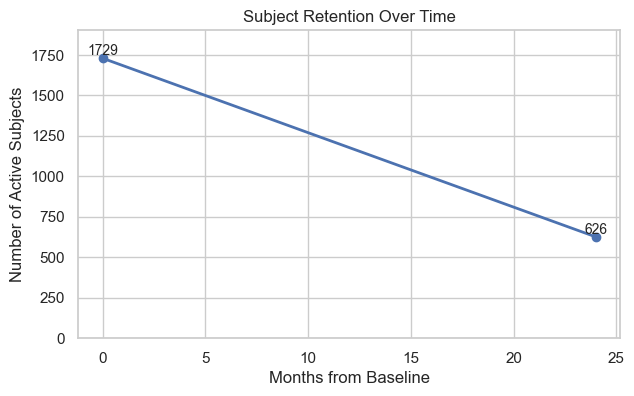

/tmp/ipykernel_21218/2829091273.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=retention.index, y=retention.values, palette="Blues_d")


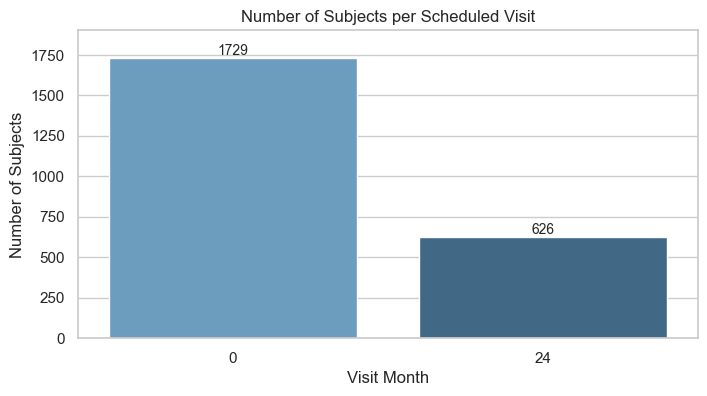

In [220]:
# Compute retention
# the number of unique subjects (Subject ID) present at each scheduled visit month (Visit_Months)
retention = (
    scheduled_df.groupby("Visit_Months", observed=True)["Subject ID"]
    .nunique()
    .sort_index()
)

# -----------------------------
# Line plot with exact numbers
# -----------------------------
plt.figure(figsize=(7, 4))
plt.plot(retention.index, retention.values, marker="o", linewidth=2)

# Annotate each point with the exact number
for x, y in zip(retention.index, retention.values):
    plt.text(x, y + 0.5, str(y), ha="center", va="bottom", fontsize=10)

plt.xlabel("Months from Baseline")
plt.ylabel("Number of Active Subjects")
plt.title("Subject Retention Over Time")
plt.grid(True)
plt.ylim(0, retention.values.max() * 1.1)
plt.show()

# -----------------------------
# Bar plot with exact numbers
# -----------------------------
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=retention.index, y=retention.values, palette="Blues_d")

# Annotate each bar with the exact number
for i, v in enumerate(retention.values):
    ax.text(i, v + 0.5, str(v), ha="center", va="bottom", fontsize=10)

plt.xlabel("Visit Month")
plt.ylabel("Number of Subjects")
plt.title("Number of Subjects per Scheduled Visit")
plt.ylim(0, retention.values.max() * 1.1)
plt.show()